In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import interpolate
import os
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.font_manager as fm
import tabulate
import matplotlib
import scipy.stats
import networkx as nx
import itertools
from sklearn import metrics
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import matplotlib.patches as mpatches
import sklearn.neighbors
from scipy.spatial import distance
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import Counter
import skimage
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import io
import numpy as np
import gget
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from skimage.color import rgb2hed, hed2rgb
from importlib import reload

import sys
sys.path.append("../")
import utils as ut
reload(ut)

from mpl_toolkits.mplot3d import Axes3D

In [2]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'global' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())


sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

normalize = True

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "global" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        if normalize:
            sdf = ut.normalize(sdf)
        spt[key] = sdf
    
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f and "global" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()

"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

df.shape=(7418, 13)
key
HFD8     3391
ND       2034
HFD14    1993
Name: count, dtype: int64
HFD8_global_spt.csv
ND_global_spt.csv
HFD14_global_spt.csv
cdf.shape=(7424, 4)
key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64

key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64


,spotId,x,y,key,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8,0.077635,0.022735,0.104811,0.111453,0.125867,0.195064,0.059765,0.111978,0.082445,0.066571,0.041676
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8,0.076987,0.041831,0.047343,0.139484,0.082711,0.093085,0.148247,0.071763,0.058744,0.142045,0.097760
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8,0.079216,0.043327,0.075868,0.086821,0.086695,0.097747,0.186142,0.090520,0.069670,0.094246,0.089748
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8,0.037682,0.029618,0.093281,0.109521,0.052151,0.061401,0.201332,0.094533,0.143671,0.088173,0.088637
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8,0.092691,0.001555,0.002745,0.075636,0.054631,0.052849,0.112912,0.008552,0.258918,0.056771,0.282740


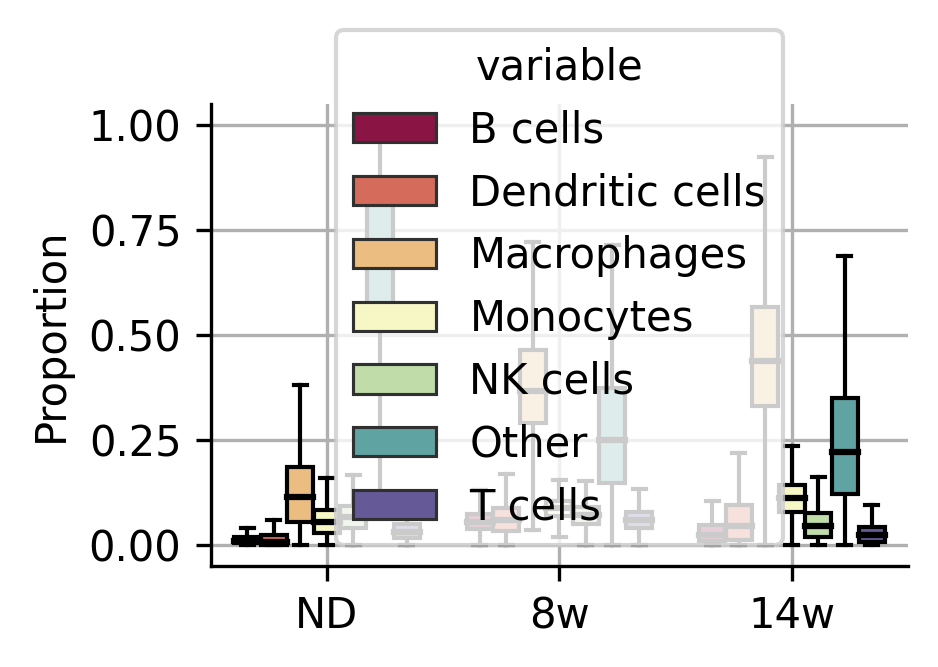

In [9]:
pdf = df.copy()

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

pdf['Macrophages'] = pdf[macTypes].sum(axis=1)

ctypes = [
    'B cells',
    'Dendritic cells',
    'Macrophages',
    # 'Mac4',
    # 'Mac5',
    'Monocytes',
    'NK cells',
    'Stromal cells',
    'T cells'
]


keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}

pdf['keyName'] = pdf['key'].map(keyMap)

pdf = pd.melt(pdf, id_vars=['spotId', 'key', 'keyName'],
              value_vars=ctypes)


pdf['variable'] = np.where(pdf['variable'] == 'Stromal cells', 'Other', pdf['variable'])
pdf.head()

pdf = pdf.sort_values(by=['key', 'variable'], ascending=[False, True])


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2
plt.rcParams['figure.facecolor'] = "w"

sns.boxplot(data=pdf, 
            x='keyName',
            y='value',
            boxprops={'edgecolor':'k', 'zorder':3, 'lw':1},
            medianprops={'color':'k', 'zorder':4},
            whiskerprops={'color':'k', 'lw':1},
            capprops={'color':'k', 'lw':1},
            # palette=[ut.MACCOLORS[3], ut.MACCOLORS[4], 'yellow'],
            palette=ut.COLORS,
            showfliers=False,
            hue='variable')

# sns.move_legend(plt.gca(), 
#                 title="",
#                 loc='lower center',
#                 ncols=3,
#                 frameon=False, 
#                 bbox_to_anchor=(0.5, -0.4))


# sns.move_legend(plt.gca(), 
#                 title="",
#                 loc='upper right',
#                 frameon=False, 
#                 bbox_to_anchor=(1.6, 1))
 
plt.ylabel("Proportion")
plt.xlabel("")
plt.grid(True, zorder=0)

sns.despine()

In [10]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "all_celltype_card_distributions.csv"
pdf.to_csv(f"{dirpath}{fname}", index=False)
pdf.head()

,spotId,key,keyName,variable,value
5388,AAACAAGTATCTCCCA.1_ND,ND,ND,B cells,0.018691
5389,AAACAGCTTTCAGAAG.1_ND,ND,ND,B cells,0.008378
5390,AAACAGGGTCTATATT.1_ND,ND,ND,B cells,0.024325
5391,AAACATTTCCCGGATT.1_ND,ND,ND,B cells,0.023002
5392,AAACCCGAACGAAATC.1_ND,ND,ND,B cells,0.021954


In [4]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
df['Mac5'].min()

In [ ]:
sorted(ctypes)

In [ ]:
ctype = "Stromal cells"

keys = ['ND', "HFD8", 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

for i, key in enumerate(keys):
    
    kdf = df[df['key'] == key]
    
    sns.scatterplot(data=kdf, 
                    x='x',
                    y='y',
                    hue=ctype,
                    s=30,
                    ec='None',
                    alpha=0.5,
                    palette='viridis',
                    ax=axs[i])
    
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].invert_yaxis()
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")

In [ ]:
pdf = df.copy()


sns.boxplot(data=df, 
            x='key',
            y='')